In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Function to scrape xG data from FBref
def scrape_fbref_xg():
    url = f"https://fbref.com/en/comps/9/2022-2023/schedule/2022-2023-Premier-League-Scores-and-Fixtures"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        table = soup.find('table', {'id': 'sched_2022-2023_9_1'})
        df = pd.read_html(str(table))[0]
        return df
    else:
        print("Failed to retrieve data")
        return None


In [ ]:
# Scrape xG data for Premier League matches the previous season
premier_league_xg = scrape_fbref_xg()
premier_league_xg = premier_league_xg.drop(columns=['Day', 'Date', 'Attendance', 'Referee', 'Venue', 'Match Report', 'Wk', 'Notes', 'Time'])
premier_league_xg = premier_league_xg.dropna()

In [ ]:
def check_xg_is_correct(row):
  scores = row.Score.split('–')
  # scores[0] is the home team, scores[1] is the away team
  winner_xg = 0
  loser_xg = 0
  home_team_score = int(scores[0])
  away_team_score = int(scores[1])
  home_xg = row['xG']
  away_xg = row['xG.1']
  total_xg = 0
  total_goals = home_team_score + away_team_score
  xg_difference = abs(row['xG'] - row['xG.1'])
  goal_difference = abs(home_team_score - away_team_score)
  if(home_team_score > away_team_score):
      winner_xg = row['xG']
      loser_xg = row['xG.1']
      total_xg = winner_xg + loser_xg
  elif(away_team_score > home_team_score):
      winner_xg = row['xG.1']
      loser_xg = row['xG']
      total_xg = winner_xg + loser_xg
  else:
      if(abs(row['xG'] - row['xG.1']) < 0.5):
        total_xg = home_xg + away_xg
        return True, xg_difference, home_team_score, away_team_score, goal_difference, total_xg, total_goals
      else:
        total_xg = home_xg + away_xg
        return False, xg_difference, home_team_score, away_team_score, goal_difference, total_xg, total_goals

  if(winner_xg > loser_xg):
    return True, xg_difference, home_team_score, away_team_score, goal_difference, total_xg, total_goals
  else:
    return False, xg_difference, home_team_score, away_team_score, goal_difference, total_xg, total_goals

for index, row in premier_league_xg.iterrows():
    # Access row data using row['column_name'] or row[index]
     xg_correct, xg_difference, home_team_score, away_team_score, goal_difference, total_xg, total_goals = check_xg_is_correct(row)
     premier_league_xg.at[index, 'xG_correct'] = xg_correct
     premier_league_xg.at[index, 'xG_difference'] = xg_difference
     premier_league_xg.at[index, 'home_team_score'] = home_team_score
     premier_league_xg.at[index, 'away_team_score'] = away_team_score
     premier_league_xg.at[index, 'goal_difference'] = goal_difference
     premier_league_xg.at[index, 'total_xg'] = total_xg
     premier_league_xg.at[index, 'total_goals'] = total_goals


In [ ]:
xg_correct_total_mean = premier_league_xg['xG_correct'].mean()
xg_difference_total_mean = premier_league_xg['xG_difference'].mean()

mean_xg_difference_when_correct = premier_league_xg.loc[premier_league_xg['xG_correct'], 'xG_difference'].mean()
incorrect_xg_difference = premier_league_xg.loc[premier_league_xg['xG_correct'] == False, 'xG_difference'].mean()



In [ ]:
print(
    'xG correct:' ,xg_correct_total_mean*100, '% \n'
    'xG difference:', xg_difference_total_mean, '\n'
    'xG difference when correct:', mean_xg_difference_when_correct, '\n'
    'xG difference when incorrect: ', incorrect_xg_difference, '\n'
)

xG correct: 67.89473684210526 % 
xG difference: 1.0028947368421053 
xG difference when correct: 1.094186046511628 
xG difference when incorrect:  0.8098360655737704 



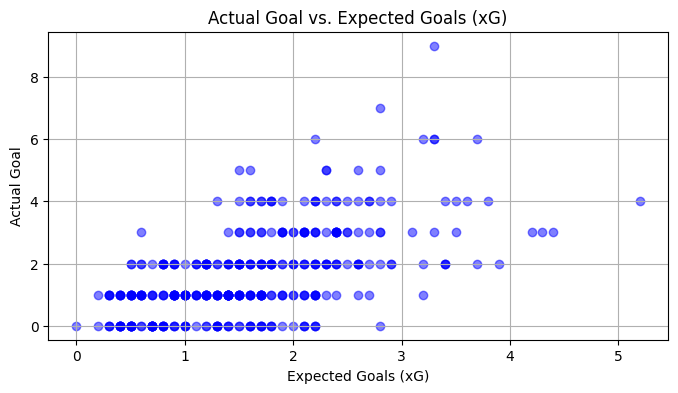

In [ ]:
# Create a scatter plot
plt.figure(figsize=(8, 4))
plt.scatter(premier_league_xg['xG'], premier_league_xg['home_team_score'], color='blue', alpha=0.5)

# Add labels and title
plt.title('Actual Goal vs. Expected Goals (xG)')
plt.xlabel('Expected Goals (xG)')
plt.ylabel('Actual Goal')

# Show plot
plt.grid(True)
plt.show()

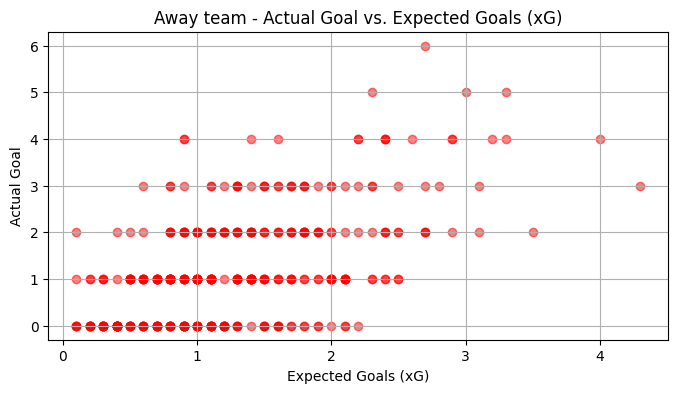

In [ ]:

# Create a scatter plot
plt.figure(figsize=(8, 4))
plt.scatter(premier_league_xg['xG.1'], premier_league_xg['away_team_score'], color='red', alpha=0.5)

# Add labels and title
plt.title('Away team - Actual Goal vs. Expected Goals (xG)')
plt.xlabel('Expected Goals (xG)')
plt.ylabel('Actual Goal')

# Show plot
plt.grid(True)
plt.show()

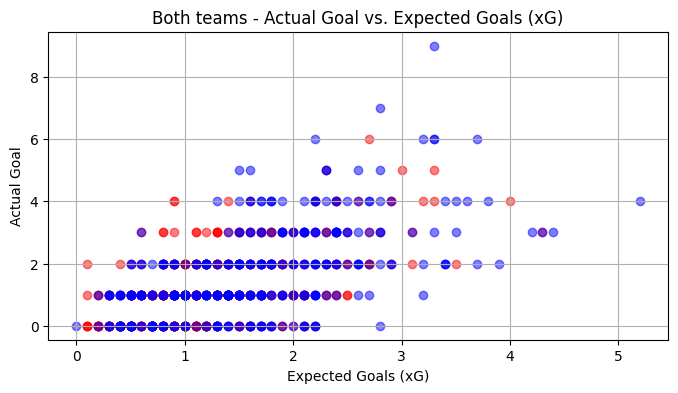

In [ ]:
# Create a scatter plot
plt.figure(figsize=(8, 4))
plt.scatter(premier_league_xg['xG.1'], premier_league_xg['away_team_score'], color='red', alpha=0.5)
plt.scatter(premier_league_xg['xG'], premier_league_xg['home_team_score'], color='blue', alpha=0.5)

# Add labels and title
plt.title('Both teams - Actual Goal vs. Expected Goals (xG)')
plt.xlabel('Expected Goals (xG)')
plt.ylabel('Actual Goal')

# Show plot
plt.grid(True)
plt.show()

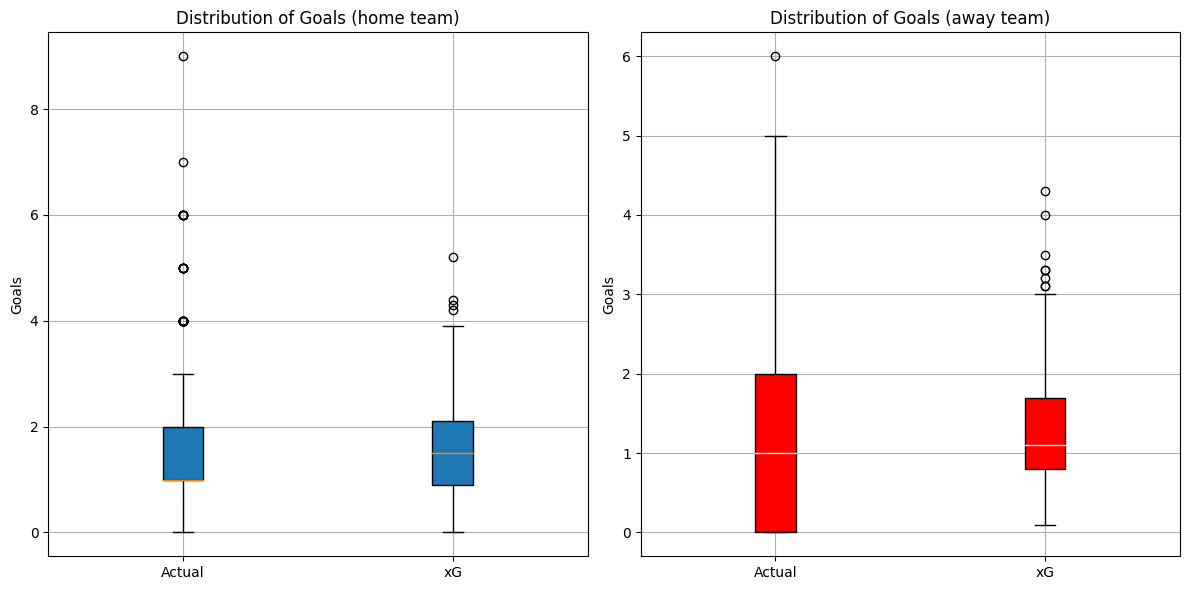

In [ ]:
# Create a figure with two subplots
plt.figure(figsize=(12, 6))

# First subplot: Box plot for xG distribution
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.boxplot([premier_league_xg['home_team_score'], premier_league_xg['xG'],], labels=['Actual', 'xG'], patch_artist=True)
plt.title('Distribution of Goals (home team)')
plt.ylabel('Goals')
plt.grid(True)

# Second subplot: Box plot for actual home and away team scores
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.boxplot([premier_league_xg['away_team_score'], premier_league_xg['xG.1']],
            labels=['Actual', 'xG'], patch_artist=True, boxprops=dict(facecolor='red', color='black'), medianprops=dict(color='white'))
plt.title('Distribution of Goals (away team)')
plt.ylabel('Goals')
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


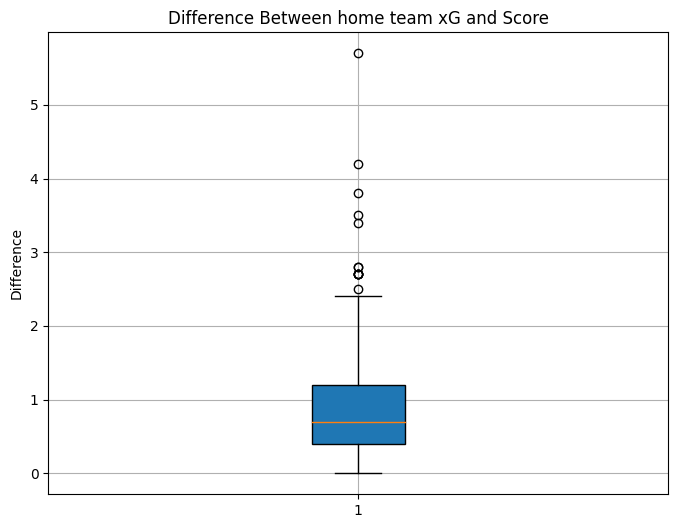

In [ ]:
# Calculate the numerical difference between xG and home_team_score
premier_league_xg['xG_home_score_difference'] = abs(premier_league_xg['xG'] - premier_league_xg['home_team_score'])

# Create a box plot to compare the numerical difference
plt.figure(figsize=(8, 6))
plt.boxplot(premier_league_xg['xG_home_score_difference'], patch_artist=True)
plt.title('Difference Between home team xG and Score')
plt.ylabel('Difference')
plt.grid(True)
plt.show()

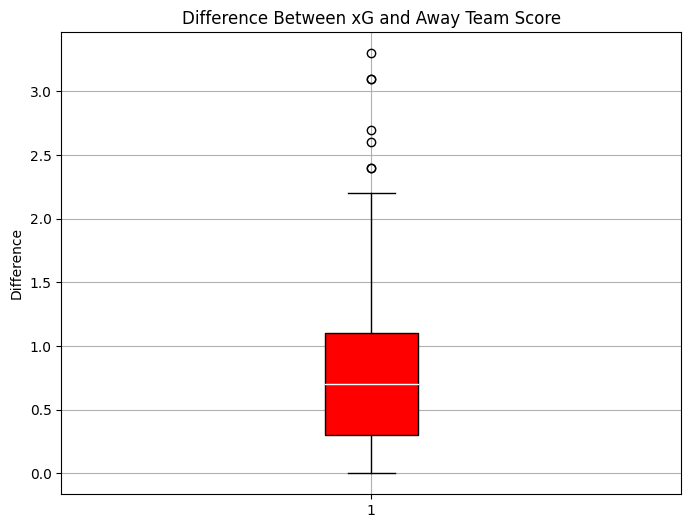

In [ ]:
# Calculate the numerical difference between xG and home_team_score
premier_league_xg['xG_away_score_difference'] = abs(premier_league_xg['xG.1'] - premier_league_xg['away_team_score'])

# Create a box plot to compare the numerical difference
plt.figure(figsize=(8, 6))
plt.boxplot(premier_league_xg['xG_away_score_difference'], patch_artist=True, boxprops=dict(facecolor='red', color='black'), medianprops=dict(color='white'))
plt.title('Difference Between xG and Away Team Score')
plt.ylabel('Difference')
plt.grid(True)
plt.show()

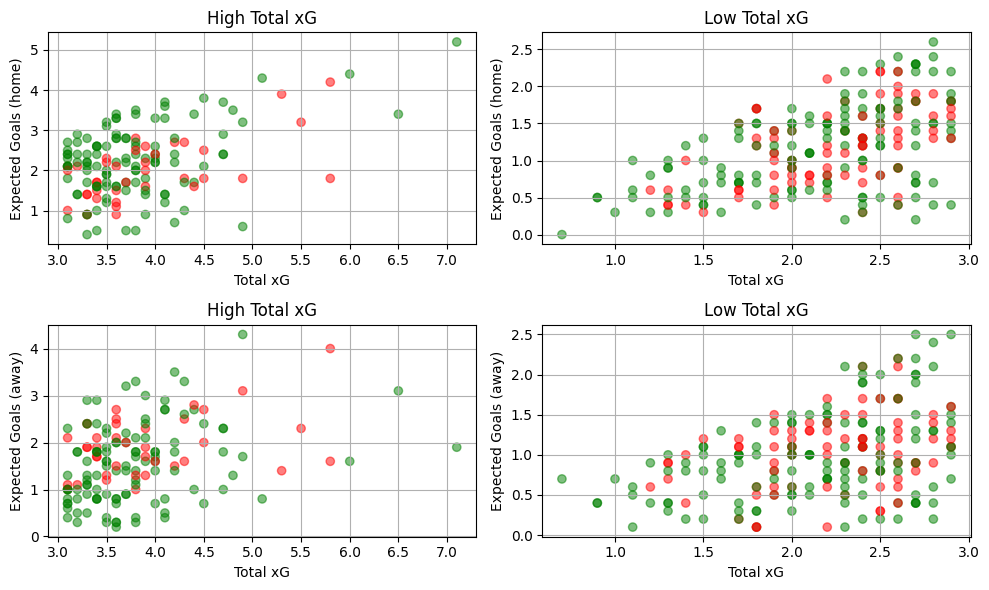

In [ ]:
high_total_xg_matches = premier_league_xg[premier_league_xg['total_xg'] > 3]
low_total_xg_matches = premier_league_xg[premier_league_xg['total_xg'] < 3]

#fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# Plot for high total_xg matches
axs[0, 0].scatter(high_total_xg_matches['total_xg'], high_total_xg_matches['xG'],
               color=high_total_xg_matches['xG_correct'].map({True: 'green', False: 'red'}),
               alpha=0.5)
axs[0, 0].set_title('High Total xG')
axs[0, 0].set_ylabel('Expected Goals (home)')
axs[0, 0].set_xlabel('Total xG')
axs[0, 0].grid(True)

# Plot for low total_xg matches
axs[0, 1].scatter(low_total_xg_matches['total_xg'], low_total_xg_matches['xG'],
               color=low_total_xg_matches['xG_correct'].map({True: 'green', False: 'red'}),
               alpha=0.5)
axs[0, 1].set_title('Low Total xG')
axs[0, 1].set_ylabel('Expected Goals (home)')
axs[0, 1].set_xlabel('Total xG')
axs[0, 1].grid(True)

# Plot for high total_xg matches
axs[1, 0].scatter(high_total_xg_matches['total_xg'], high_total_xg_matches['xG.1'],
               color=high_total_xg_matches['xG_correct'].map({True: 'green', False: 'red'}),
               alpha=0.5)
axs[1, 0].set_title('High Total xG')
axs[1, 0].set_ylabel('Expected Goals (away)')
axs[1, 0].set_xlabel('Total xG')
axs[1, 0].grid(True)

# Plot for low total_xg matches
axs[1, 1].scatter(low_total_xg_matches['total_xg'], low_total_xg_matches['xG.1'],
               color=low_total_xg_matches['xG_correct'].map({True: 'green', False: 'red'}),
               alpha=0.5)
axs[1, 1].set_title('Low Total xG')
axs[1, 1].set_ylabel('Expected Goals (away)')
axs[1, 1].set_xlabel('Total xG')
axs[1, 1].grid(True)
# Adjust layout
plt.tight_layout()

# Show plots
plt.show()